# Image Classification using Convolutional Neural Networks in PyTorch


Here in this notebook, I will perform these following tasks:

- Downloading an image dataset from web URL
- Understanding convolution and pooling layers
- Creating a convolutional neural network (CNN) using PyTorch
- Training a CNN from scratch and monitoring performance
- Underfitting, overfitting and how to overcome them

## Exploring the CIFAR10 Dataset


<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

I'll download the images in PNG format from (https://course.fast.ai/datasets), using some helper functions from the `torchvision` and `tarfile` packages.

In [3]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [4]:
#Extract from archive
with tarfile.open('./cifar10.tgz' , 'r:gz') as tar:
  tar.extractall(path='./data')

The dataset is extracted to the directory `data/cifar10`. It contains 2 folders `train` and `test`, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using `os.listdir`.

In [5]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['automobile', 'truck', 'deer', 'airplane', 'frog', 'bird', 'cat', 'dog', 'horse', 'ship']


Let's look inside a couple of folders, one from the training set and another from the test set. Let's verify that that there are an equal number of images for each class, 5000 in the training set and 1000 in the test set.

In [6]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('Mo. of training examples for airplanes:' , len(airplane_files))
print(airplane_files[:5])

Mo. of training examples for airplanes: 5000
['2786.png', '4690.png', '3436.png', '3472.png', '4040.png']


In [7]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print('Mo. of test examples for ship:' , len(ship_test_files))
print(ship_test_files[:5])

Mo. of test examples for ship: 1000
['0318.png', '0849.png', '0689.png', '0415.png', '0945.png']


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [9]:
dataset = ImageFolder(data_dir+ '/train', transform= ToTensor())

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape `(3, 32, 32)`.

In [10]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

The list of classes is stored in the `.classes` property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [11]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


We can view the image using `matplotlib`, but we need to change the tensor dimensions to `(32,32,3)`. Let's create a helper function to display an image and its label.

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [13]:
def show_example(img, label):
  print('Label: ', dataset.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1, 2, 0))

Let's look at a couple of images from the dataset.

Label:  airplane (0)


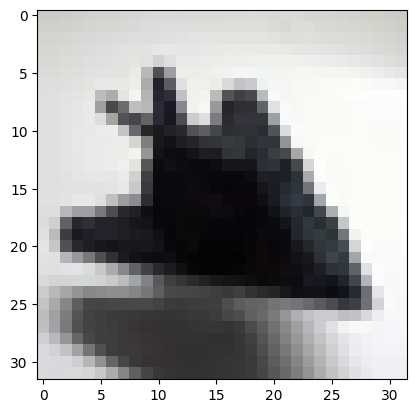

In [14]:
show_example(*dataset[0])

Label:  airplane (0)


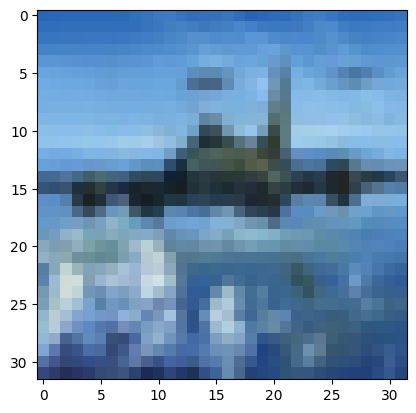

In [15]:
show_example(*dataset[120])

Label:  airplane (0)


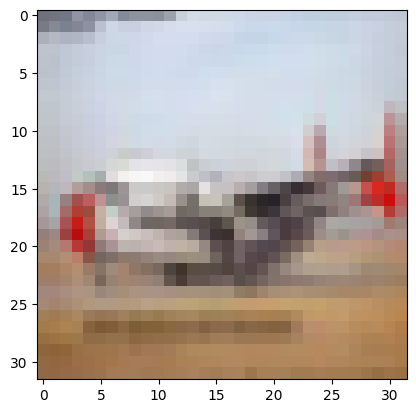

In [16]:
show_example(*dataset[1099])

Label:  airplane (0)


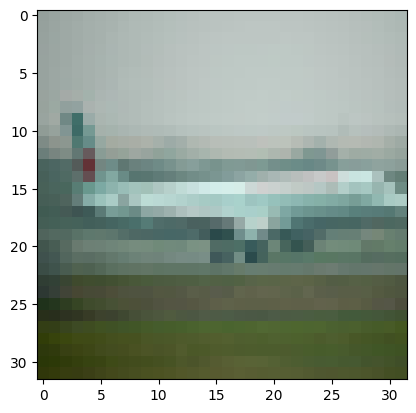

In [17]:
show_example(*dataset[1544])

Label:  airplane (0)


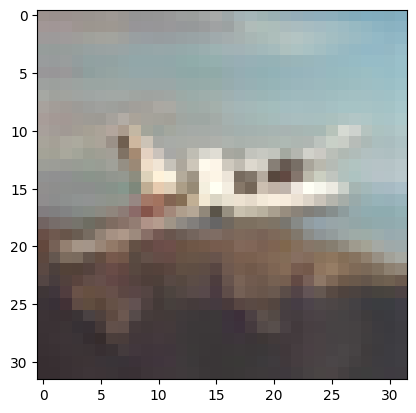

In [19]:
show_example(*dataset[1984])

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [20]:
random_seed = 42
torch.manual_seed(random_seed)

In [21]:
val_size = 10000
train_size = len(dataset) - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds) , len(val_ds)

(40000, 10000)

Now, Let's create data loaders for training and validation, to load the data in batches

In [22]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

In [23]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers=2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory = True)


To check or view the batches of images from the dataset `make_grid` method from `torchvision` is used. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [25]:
from torchvision.utils import make_grid

In [26]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize= (12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow= 16).permute(1, 2, 0))
    break


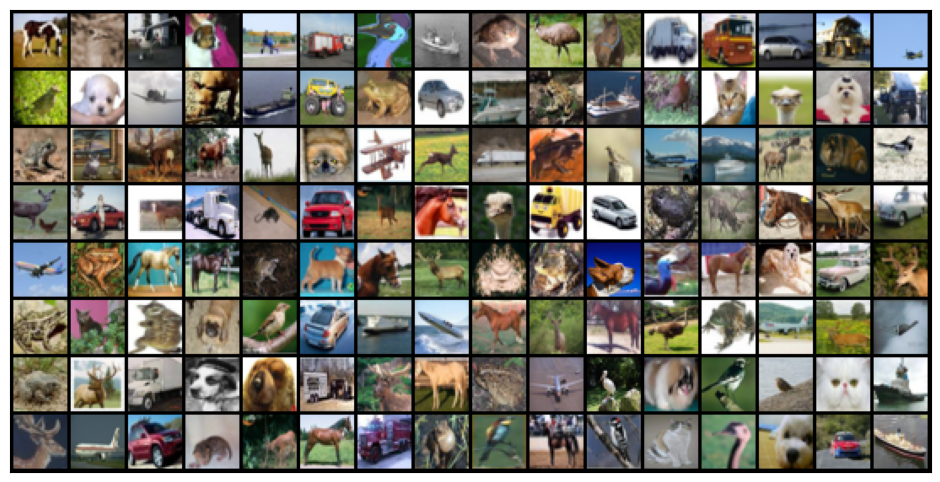

In [27]:
show_batch(train_dl)

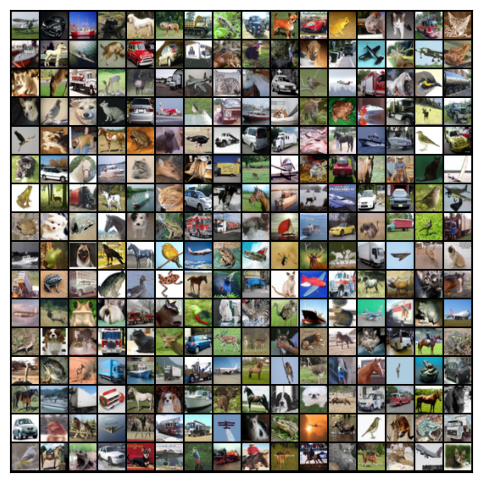

In [28]:
show_batch(val_dl)

## Defining the Model (Convolutional Neural Network)

Here, for convolutional neural network `nn.Conv2d` class from PyTorch will used.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

In [29]:
def apply_kernel(image, kernel):
  ri, ci = image.shape
  rk, ck = kernel.shape
  ro, co = ri - rk+1 , ci-ck+1
  output = torch.zeros([ro, co])
  for i in range(ro):
    for j in range(co):
      output[i, j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
  return output



In [30]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
], dtype=torch.float32)



In [31]:
apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise.


There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer.
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

In [33]:
import torch.nn as nn
import torch.nn.functional as F

In [37]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [38]:
for images, labels in train_dl:
  print('images.shape:' , images.shape)
  out = simple_model(images)
  print('out.shape:',  out.shape)
  break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [39]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [49]:
class Cifar10CnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(32, 64, kernel_size=3, stride = 1,padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, 2),


                                 nn.Conv2d(64, 128, kernel_size=3,stride = 1, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(128, 128, kernel_size=3,stride = 1, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, 2),


                                 nn.Conv2d(128, 256, kernel_size=3, stride = 1, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(256, 256, kernel_size=3, stride = 1, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, 2),

                                 nn.Flatten(),
                                 nn.Linear(256*4*4, 1024),
                                 nn.ReLU(),
                                 nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Linear(512, 10),
                                  )
  def forward(self, xb):
    return self.network(xb)


In [50]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image.

In [51]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0002, -0.0075,  0.0209, -0.0405,  0.0274,  0.0391, -0.0351, -0.0233,
         0.0293, -0.0146], grad_fn=<SelectBackward0>)


To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [52]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [53]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [54]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set.

In [55]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [56]:
model = to_device(Cifar10CnnModel(), device)

In [57]:
evaluate(model, val_dl)

{'val_loss': 2.303229570388794, 'val_acc': 0.09814453125}

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time.

In [58]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [73]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0980, val_loss: 1.3034, val_acc: 0.7424
Epoch [1], train_loss: 0.0889, val_loss: 1.4078, val_acc: 0.7454
Epoch [2], train_loss: 0.0897, val_loss: 1.3374, val_acc: 0.7472
Epoch [3], train_loss: 0.0889, val_loss: 1.5015, val_acc: 0.7504
Epoch [4], train_loss: 0.0743, val_loss: 1.4799, val_acc: 0.7538
Epoch [5], train_loss: 0.0787, val_loss: 1.3783, val_acc: 0.7476
Epoch [6], train_loss: 0.0845, val_loss: 1.3319, val_acc: 0.7447
Epoch [7], train_loss: 0.0745, val_loss: 1.3998, val_acc: 0.7446
Epoch [8], train_loss: 0.0566, val_loss: 1.4994, val_acc: 0.7466
Epoch [9], train_loss: 0.0620, val_loss: 1.5910, val_acc: 0.7563


In [72]:
history1 = fit(5, 0.0001, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0027, val_loss: 2.2590, val_acc: 0.7689
Epoch [1], train_loss: 0.0011, val_loss: 2.2633, val_acc: 0.7728
Epoch [2], train_loss: 0.0002, val_loss: 2.3534, val_acc: 0.7724
Epoch [3], train_loss: 0.0001, val_loss: 2.4380, val_acc: 0.7729
Epoch [4], train_loss: 0.0001, val_loss: 2.5209, val_acc: 0.7734


We can also plot the valdation set accuracies to study how the model improves over time.

In [74]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history + history1]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

Our model reaches an accuracy of around 75%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than 80% even after training for a long time. This suggests that we might need to use a more powerful model to capture the relationship between the images and the labels more accurately. This can be done by adding more convolutional layers to our model, or incrasing the no. of channels in each convolutional layer, or by using regularization techniques.

We can also plot the training and validation losses to study the trend.

In [75]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history + history1]
    val_losses = [x['val_loss'] for x in history + history1]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

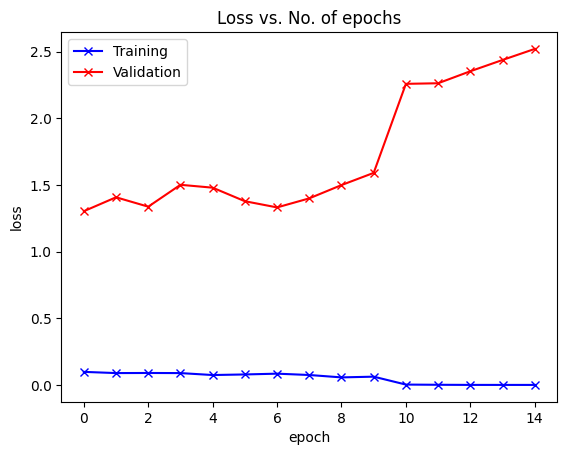

In [76]:
plot_losses(history)

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point!

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.


Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase



## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by creating a test dataset using the `ImageFolder` class.


In [63]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [64]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


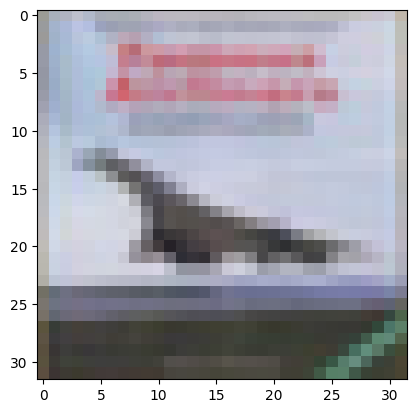

In [65]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


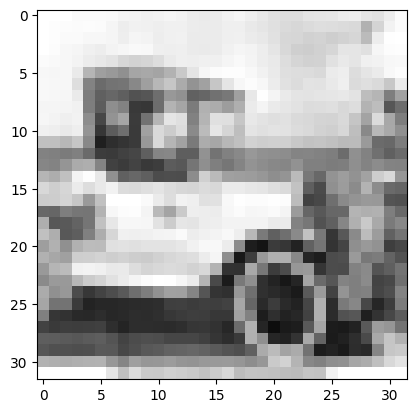

In [66]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.



In [77]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.6733360290527344, 'val_acc': 0.741406261920929}